<a href="https://colab.research.google.com/github/RossanadC/Machine-Learning/blob/main/GradCAM_Pytorch_CatsvsDogs_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from tensorboard.plugins import projector
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [ ]:
from google.colab import files

#upload kaggle.json
files.upload()


!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/Lab03/dogs-vs-cats.zip
!unzip /content/drive/MyDrive/ColabNotebooks/Lab03/train.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Define pre-trained model
num_classes = 2
input_shape = (3, 224, 224)  # PyTorch uses (channels, height, width) for input shape

path_to_saved_model = '/content/drive/MyDrive/catsvsdogs.pth'
model  = torch.hub.load('pytorch/vision', 'resnet18', weights=False)

model.fc = nn.Sequential(nn.Linear(model.fc.in_features,128),
                                  nn.ReLU(),
                                  nn.Linear(128, num_classes))

model.load_state_dict(torch.load(path_to_saved_model))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [ ]:
from torchvision import datasets, transforms

# preprocessing to apply on each data sample:
# 1) convert to tensor
# 2) normalize images
img_dimensions = 224

transform = transforms.Compose([
    transforms.Resize((img_dimensions, img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])



In [ ]:
train_dir = 'train'


In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list ,transform = None):
        self.file_list=file_list
        self.transform=transform

    def __len__(self):
        self.filelength =len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path =self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0

        return img_transformed,label, img_path

In [ ]:
import glob
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))



In [ ]:
data = dataset(train_list,transform=transform)
batch_size = 1
loader = torch.utils.data.DataLoader(dataset = data, batch_size = batch_size,shuffle = False)

In [ ]:
# Select target layer for GradCAM
target_layer = model.layer4[-1]

In [ ]:
# Hook to capture gradients of the target layer
gradients = []

def save_gradient(grad):
    gradients.append(grad)

# Forward pass to get predictions and hook the feature map
def forward_pass_with_hooks(x):
    activations = []
    def forward_hook(module, input, output):
        activations.append(output)
        output.register_hook(save_gradient)

    handle = target_layer.register_forward_hook(forward_hook)
    preds = model(x)
    handle.remove()
    return activations, preds

In [ ]:

# Compute Grad-CAM
def compute_gradcam(activations, grads):
    pooled_grads = torch.mean(grads[0], dim=[0, 2, 3])  # Global average pooling
    activations = activations[0][0]  # Remove batch dimension
    for i in range(pooled_grads.shape[0]):
        activations[i, :, :] *= pooled_grads[i]
    heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU to zero out negative values
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    return heatmap

# Overlay heatmap on the original image
def overlay_heatmap(img, heatmap, alpha=0.4, colormap='jet'):
    img = Image.fromarray(img)
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size, Image.BILINEAR)
    heatmap = np.array(heatmap)
    heatmap = plt.get_cmap(colormap)(heatmap)[:, :, :3]  # Apply colormap
    heatmap = Image.fromarray(np.uint8(heatmap * 255))

    # Combine original image with heatmap
    overlayed_img = Image.blend(img, heatmap, alpha)
    return overlayed_img


In [ ]:

# Run Grad-CAM and visualize
def gradcam_visualization(img_tensor, original_img, class_idx=None):

    activations, preds = forward_pass_with_hooks(img_tensor)



    if class_idx is None:
        class_idx = preds.argmax().item()  # Use the predicted class if not specified



    # Backward pass to get gradients
    model.zero_grad()
    preds[:, class_idx].backward()

    # Compute Grad-CAM
    heatmap = compute_gradcam(activations, gradients)

    # Visualize
    overlayed_img = overlay_heatmap(original_img, heatmap)
    print(overlayed_img.size)


    # Plot the original image, heatmap, and overlayed image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlayed Image")
    plt.imshow(overlayed_img)
    plt.axis('off')

    plt.show()


In [ ]:
iter_data = iter(loader)



In [ ]:
input_tensor, label, _ = next(iter_data)
input_tensor = input_tensor.to(device)

In [ ]:
img = input_tensor.cpu().detach().numpy()
img = img[0,:].transpose(1,2,0)
img = img*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img = (img*255).astype(np.uint8)



(224, 224)


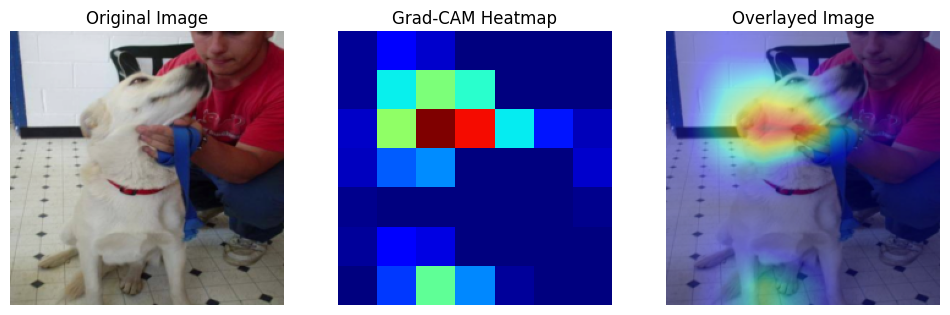

In [ ]:
# Run the Grad-CAM visualization
gradcam_visualization(input_tensor, img)